In [31]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import round_n
set_plot_params()

from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

import argparse
from neuroformer.SpikeVidUtils import round_n
import gdown


# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

set_seed(25)

def parse_args():
    parser = argparse.ArgumentParser()
    # parser.add_argument("--infer", action="store_true", help="Inference mode")
    parser.add_argument("--train", action="store_true", default=False, help="Train mode")
    parser.add_argument("--resume", type=str, default=None, help="Resume from checkpoint")
    parser.add_argument("--rand_perm", action="store_true", default=False, help="Randomly permute the ID column")
    parser.add_argument("--mconf", type=str, default=None, help="Path to model config file")
    parser.add_argument("--downstream", action="store_true", default=False, help="Downstream task")
    parser.add_argument("--freeze_model", action="store_true", default=False, help="Freeze model")
    parser.add_argument("--title", type=str, default=None)
    parser.add_argument("--dataset", type=str, default="Combo3_V1AL")
    parser.add_argument("--behavior", action="store_true", default=False, help="Behavior task")
    parser.add_argument("--pred_behavior", action="store_true", default=False, help="Predict behavior")
    parser.add_argument("--past_state", action="store_true", default=False, help="Input past state")
    parser.add_argument("--visual", action="store_true", default=False, help="Visualize")
    parser.add_argument("--contrastive", action="store_true", default=False, help="Contrastive")
    parser.add_argument("--clip", action="store_true", default=False, help="Clip loss")
    return parser.parse_args()

# if __name__ == "__main__":
#     args = parse_args()
#     INFERENCE = not args.train
# else:
#     INFERENCE = True

# check if jupyter notebook
try:
    shell = get_ipython().__class__.__name__
    print("Running in Jupyter notebook")
    INFERENCE = True
    DOWNSTREAM = False
    RESUME = None
    RAND_PERM = False
    MCONF = "./models/tensorboard/Combo3_V1AL/ablations/downstream:False/past_state_True_visualTrue_contrastive_False_freeze_False/randperm_False/Big_fixed_noself-att_2/sparse_f:None_id:None/w:0.05_wp:0.25/mconf.yaml"
    FREEZE_MODEL = False
    TITLE = None
    DATASET = "Combo3_V1AL"
    BEHAVIOR = False
    PREDICT_BEHAVIOR = False
    VISUAL = True
    PAST_STATE = True
    CONTRASTIVE = False
    CLIP = False
except:
    print("Running in terminal")
    args = parse_args()
    INFERENCE = not args.train
    DOWNSTREAM = args.downstream
    RESUME = args.resume
    RAND_PERM = args.rand_perm
    MCONF = args.mconf
    FREEZE_MODEL = args.freeze_model
    DATASET = args.dataset
    BEHAVIOR = args.behavior
    PREDICT_BEHAVIOR = args.pred_behavior
    VISUAL = args.visual
    PAST_STATE = args.past_state
    CONTRASTIVE = args.contrastive
    CLIP = args.clip

print(f"CONTRASTIUVEEEEEEE {CONTRASTIVE}")
print(f"VISUAL: {VISUAL}")
print(f"PAST_STATE: {PAST_STATE}")

Running in Jupyter notebook
CONTRASTIUVEEEEEEE False
VISUAL: True
PAST_STATE: True


In [32]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing


"""

if DATASET == "Combo3_V1AL":
    RESPONSE_PATH = "data/Combo3_V1AL/Combo3_V1AL_response.csv"
    STIMULUS_PATH = "data/Combo3_V1AL/Combo3_V1AL_stimulus.pt"

# if not os.path.exists(RESPONSE_PATH):
#     print("Downloading data...")
#     url = "https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=share_link"
#     gdown.download_folder(id=url, quiet=False, use_cookies=False, output=os.path.dirname(RESPONSE_PATH))
# else:
from neuroformer.prepare_data import DataLinks
DataLinkDS = getattr(DataLinks, DATASET)
url = DataLinkDS['url']
RESPONSE_PATH = DataLinkDS['RESPONSE_PATH']
STIMULUS_PATH = DataLinkDS['STIMULUS_PATH']
# gdown.download_folder(id=url)


df = pd.read_csv(RESPONSE_PATH)
video_stack = torch.load(STIMULUS_PATH)
stimulus = video_stack[:, :, 0]

torch.Size([3, 640, 1, 64, 112])


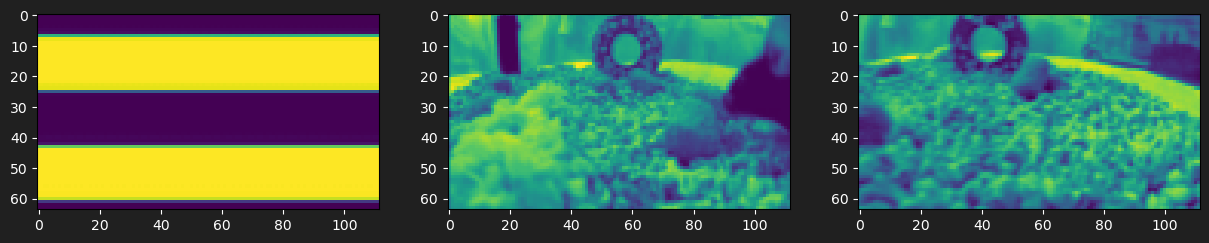

In [33]:
print(video_stack.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(video_stack[i, 1, 0].permute(0, 1))




In [34]:
# load config files
import yaml

# base_path = "configs/visnav/predict_behavior"
if MCONF is not None:
    base_path = os.path.dirname(MCONF)
elif RESUME is not None:
    base_path = os.path.dirname(RESUME)
else:
    base_path = "./models/tensorboard/V1_AL/downstream/learnt_temporal_embeddings/sparse_f:None_id:None/w:0.05_wp:0.25"
    

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)


In [35]:

if INFERENCE:
    frame_window = mconf.frame_window
    window = mconf.window
    window_prev = mconf.window_prev
    window_behavior = mconf.window_behavior if hasattr(mconf, 'window_behavior') else None
    dt = mconf.dt
    dt_frames = mconf.dt_frames if hasattr(mconf, 'dt_frames') else 0.05
    dt_vars = mconf.dt_vars if hasattr(mconf, 'dt_vars') else 0.05
    dt_speed = mconf.dt_speed if hasattr(mconf, 'dt_speed') else 0.2
    intervals = None
else:
    frame_window = 0.25
    window = 0.05
    window_prev = 0.25
    window_behavior = window
    dt = 0.01
    dt_frames = 0.05
    dt_vars = 0.05
    dt_speed = 0.2
    intervals = None

# randomly permute 'id' column
if RAND_PERM:
    df['ID'] = df['ID'].sample(frac=1, random_state=25).reset_index(drop=True)



In [36]:
## choose modalities ##

# behavior
behavior = BEHAVIOR
behavior_vars = ['eyerad', 'phi', 'speed', 'th']
# behavior_vars = ['speed']
n_behavior = len(behavior_vars)
predict_behavior = PREDICT_BEHAVIOR
# stimulus
visual_stim = VISUAL



In [37]:
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals


if behavior is True:
    behavior = pd.DataFrame({k: data[k] for k in behavior_vars + ['t']})
    # rename t to time
    behavior = behavior.rename(columns={'t': 'Time'}) if behavior is not None else None
    behavior['Interval'] = make_intervals(behavior, window)
    behavior['Interval_2'] = make_intervals(behavior, window_prev)

    # prepare speed variables
    behavior['speed'] = behavior['speed'].apply(lambda x: round_n(x, dt_speed))
    dt_range_speed = behavior['speed'].min(), behavior['speed'].max()
    dt_range_speed = np.arange(dt_range_speed[0], dt_range_speed[1] + dt_speed, dt_speed)
    n_behavior = len(dt_range_speed)

    stoi_speed = { round_n(ch, dt_speed):i for i,ch in enumerate(dt_range_speed) }
    itos_speed = { i:round_n(ch, dt_speed) for i,ch in enumerate(dt_range_speed) }
    assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
    samples_per_behavior = int((window + window_prev) // dt_vars)
    behavior_block_size = int((window + window_prev) // dt_vars) * (len(behavior.columns) - 1)
else:
    behavior = None
    behavior_vars = None
    behavior_block_size = 0
    samples_per_behavior = 0
    stoi_speed = None
    itos_speed = None
    dt_range_speed = None
    n_behavior = None

if predict_behavior:
    loss_bprop = ['behavior']
else:
    loss_bprop = None




In [38]:
from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

# randomly permute 'id' column
if RAND_PERM:
    print('// randomly permuting ID column //')
    df['ID'] = df['ID'].sample(frac=1, random_state=25).reset_index(drop=True)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']




In [39]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
# kernel_size = (n_frames, 4, 4)
kernel_size = [n_frames, 8, 8]
stride_size = [n_frames, 4, 4]
padding_size = 0
n_embd = 256
n_embd_frames = 64
frame_feats = stimulus if visual_stim else None
frame_block_size = 0
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

prev_id_block_size = 55
id_block_size = 55   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }



/tmp/ipykernel_150726/1000346883.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame_feats = torch.tensor(stimulus, dtype=torch.float32)


In [63]:
df['Interval_2'].unique()

array([ 0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,
        2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,
        4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,
        7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,
        9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25,
       11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 ,
       13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75,
       16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75, 18.  ,
       18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  , 20.25,
       20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 ,
       22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 , 24.75,
       25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75, 27.  ,
       27.25, 27.5 , 28.  , 28.25, 28.5 , 28.75, 29.  , 29.25, 29.5 ,
       29.75, 30.  , 30.25, 30.5 , 30.75, 31.  , 31.25, 31.5 , 31.75,
       32.  , 27.75]

In [40]:
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
train_trials = random.sample(all_trials, int(len(all_trials) * r_split))

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]

# r_split_ft = np.arange(0, 1, 0.25)
r_split_ft = 0.1
finetune_trials = train_trials[:int(len(train_trials) * r_split_ft)]
finetune_data = df[df['Trial'].isin(finetune_trials)]

n = []
n_trial = [2, 8, 14, 19]
for n_stim in range(df['Trial'].max() // 20):
    # n_trial = [2, 4, 6, 8, 10, 12, 14, 18]
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t)
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)



In [41]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset=DATASET,
                                  behavior=behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed, labels=True)

if INFERENCE:
    update_object(train_dataset, dconf)
    train_dataset = train_dataset.copy(train_data)
    test_dataset = train_dataset.copy(test_data)
    finetune_dataset = train_dataset.copy(finetune_data)
    
print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')



Population Size:  389
ID Population Size:  389
DT Population Size:  28
train: 20316, test: 5334


In [42]:

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 250
batch_size = round((32 * 2))
shuffle = True

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=8, n_state_history_layers=8,
                        n_stimulus_layers=8, self_att_layers=0,
                        n_behavior_layers=0, predict_behavior=predict_behavior, n_behavior=n_behavior,
                        n_head=4, n_embd=n_embd, 
                        contrastive=False, clip_emb=1024, clip_temp=mconf.clip_temp,
                        conv_layer=conv_layer, kernel_size=kernel_size, stride_size=stride_size, padding_size=padding_size,
                        temp_emb=mconf.temp_emb, pos_emb=False,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35

if INFERENCE or MCONF is not None:
    update_object(model_conf, mconf)

if PAST_STATE is False:
    print(f"// -- No past state, layers=0 -- //")
    model_conf.n_state_history_layers = 0

if CONTRASTIVE is True:
    print(f"// -- contrastive objective -- //")
    model_conf.contrastive = True
else:
    print(f"// -- no contrastive objective -- //")
    model_conf.contrastive = False

if VISUAL is False:
    print(f"// -- No visual, layers=0 -- //")
    model_conf.n_stimulus_layers = 0

model = GPT(model_conf)

if RESUME is not None:
    # update_object(model_conf, mconf)
    print(f"// -- Loading model from {RESUME} -- //")
    model.load_state_dict(torch.load(RESUME), strict=False)
    if not DOWNSTREAM:
        model_path = f"{RESUME[:-3]}_resume.pt"


title =  f'epoch250_rand{RAND_PERM}_downstream:{DOWNSTREAM}/past_state_{PAST_STATE}_visual{VISUAL}_contrastive_{CONTRASTIVE}_freeze_{FREEZE_MODEL}/randperm_{RAND_PERM}/Big_fixed_noself-att'

if INFERENCE:
    model_path = glob.glob(os.path.join(base_path, '**.pt'), recursive=True)[0]
else:
    model_path = f"""./models/tensorboard/{DATASET}/pretrain/{title}_2/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{mconf.window}_wp:{mconf.window_prev}/Cont:{mconf.contrastive}_window:{mconf.window}_f_window:{mconf.frame_window}_df:{mconf.dt}_blocksize:{mconf.id_block_size}_conv_{mconf.conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""


// -- no contrastive objective -- //
256 28


04/27/2023 01:48:08 - INFO - neuroformer.model_neuroformer -   number of parameters: 3.200077e+07


In [43]:

if DOWNSTREAM:
    print(f"// Downstream Objective: {DOWNSTREAM} //")
    """
    image indexes

    (140, 260)
    (339, 424)
    (500, 620)
    (680, 840) 
    (960, 1050)

    """
    import tifffile
    from neuroformer.SpikeVidUtils import get_interval_idx
    from neuroformer.modules import ClassifierWrapper

    stim2_path = "./data/Combo3_V1AL/stimuli/Combined Stimuli 3-Movie2.tif"
    stimulus_2 = tifffile.imread(stim2_path)

    stim3_path = "./data/Combo3_V1AL/stimuli/Combined Stimuli 3-Movie3.tif"
    stimulus_3 = tifffile.imread(stim3_path)

    mouse_indexes = [(140, 260), (339, 424), (500, 620), (680, 840), (960, 1050)]
    stimulus_mice = np.concatenate([stimulus_2[i[0]:i[1]] for i in mouse_indexes])
    stimulus_control = np.concatenate([stimulus_3[i[0]:i[1]] for i in mouse_indexes])
    assert stimulus_mice.shape == stimulus_control.shape, "stimulus shapes must be equal"

    control_labels = np.zeros(stimulus_control.shape[0])
    mice_labels = np.ones(stimulus_mice.shape[0])
    stimulus_task = np.concatenate([stimulus_control, stimulus_mice])
    labels_task = np.concatenate([control_labels, mice_labels])
    mouse_indexes_downsampled = [tuple(map(lambda x: x // 3, i)) for i in mouse_indexes]
    stim_2_ds = stimulus[1]
    stim_2_ds_mice = np.concatenate([stim_2_ds[i[0]:i[1]] for i in mouse_indexes_downsampled])
    mouse_indexes_intervals = [tuple(map(lambda x: get_interval_idx(x, 0.05), i)) for i in mouse_indexes_downsampled]
    intervals_cls = np.concatenate([np.arange(i[0], i[1], window) for i in mouse_indexes_intervals])
    # don't use same intervals for training and testing (because images will be the same)
    train_interval_cls = np.random.choice(intervals_cls, size=int(len(intervals_cls) * 0.8), replace=False)
    test_interval_cls = np.setdiff1d(intervals_cls, train_interval_cls)
    train_trial_cls = train_data[train_data['Trial'] > 20]['Trial'].unique()
    test_trial_cls = test_data[test_data['Trial'] > 20]['Trial'].unique()
    train_interval_trial_cls = np.array(np.meshgrid(train_interval_cls, train_trial_cls)).T.reshape(-1, 2)
    test_interval_trial_cls = np.array(np.meshgrid(test_interval_cls, test_trial_cls)).T.reshape(-1, 2)
    train_dataset = train_dataset.copy(train_data, t=train_interval_trial_cls)
    test_dataset = test_dataset.copy(test_data, t=test_interval_trial_cls)



In [44]:
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e4, 
                    decay_weights=True, weight_decay=0.1, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_every=20, loss_bprop=loss_bprop)

if not INFERENCE:
    trainer = Trainer(model, train_dataset, test_dataset, tconf, model_conf)
    if DOWNSTREAM:
        mconf.__setattr__('freeze_model', FREEZE_MODEL)
        trainer.config.__setattr__('warmup_tokens', 100)
        N_CLASSES = 2
        classifier = ClassifierWrapper(model, mconf, N_CLASSES)
        train_model = classifier

    else:
        train_model = model
    trainer = Trainer(train_model, train_dataset, test_dataset, tconf, model_conf)
    trainer.train()
else:
    model_path = glob.glob(os.path.join(base_path, '**.pt'), recursive=True)[0]
    print(f"Loading model from {model_path}")
    model.load_state_dict(torch.load(model_path), strict=False)


Loading model from ./models/tensorboard/Combo3_V1AL/ablations/downstream:False/past_state_True_visualTrue_contrastive_False_freeze_False/randperm_False/Big_fixed_noself-att_2/sparse_f:None_id:None/w:0.05_wp:0.25/Cont:False_window:0.05_f_window:0.25_df:0.01_blocksize:55_conv_True_shuffle:True_batch:64_sparse_(None_None)_blocksz110_pos_emb:False_temp_emb:True_drop:0.1_dt:True_2.0_27_max0.01_(8, 8, 8)_8_256.pt


In [45]:
loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)



In [46]:
# model.eval()
# # model.train()
# for i in range(1):
#     x, y = next(iterable)
#     x_1 = x['id'][0].detach().cpu().numpy()
#     x_pad = x['pad']
#     x_1 = x['id'][:len(x_1) - int(x_pad[0])]
#     preds, features, loss = model(x, y)

#     step_choices = random.sample(range(len(x_1)), min(5, len(x_1)))
#     fig, ax = plt.subplots(1, len(step_choices), figsize=(50, 5))
#     for step in step_choices:
#         step_preds = preds['id'][0, step].detach().cpu().numpy()
#         x_axis = np.arange(0, len(step_preds))
#         ax_step = ax[step]
#         ax_step.scatter(x_axis, step_preds)
#         ax_step.set_title(f"""{step}""", fontsize=20)


In [47]:
x, y = next(iterable)
for k in x.keys():
    print(k, x[k].shape)

id_prev torch.Size([1, 55])
dt_prev torch.Size([1, 55])
pad_prev torch.Size([1])
id torch.Size([1, 55])
dt torch.Size([1, 55])
pad torch.Size([1])
interval torch.Size([1])
trial torch.Size([1])
frames torch.Size([1, 1, 5, 64, 112])
stimulus torch.Size([1])
cid torch.Size([1, 2])
pid torch.Size([1, 2])
f_idx torch.Size([1, 2])


In [57]:
preds, features, loss = model(x, y)

In [65]:
from neuroformer.utils import predict_raster_recursive_time_auto, process_predictions

PARALLEL = True
df_pred_path = None

model.load_state_dict(torch.load(model_path))

results_dict = dict()
df_pred = None if df_pred_path is None else pd.read_csv(df_pred_path)
df_true = None

top_p = 0.75
top_p_t = 0.75
temp = 1.25
temp_t = 1.25

trials = sorted(train_data['Trial'].unique())[::4]

if df_pred_path is None:
    from joblib import Parallel, delayed
    # Define a function to process each trial
    def process_trial(model, train_dataset, df, stoi, itos_dt, itos, window, window_prev, top_p, top_p_t, temp, temp_t, trial):
        print(f"-- No. {n} Trial: {trial} --")
        df_trial = df[df['Trial'] == trial]
        trial_dataset = train_dataset.copy(df_trial)
        results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                        sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                        frame_end=0, get_dt=True, gpu=False, pred_dt=True, plot_probs=False)
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        return df_trial_pred, df_trial_true

    if PARALLEL:
        # Process each trial in parallel
        results = Parallel(n_jobs=-1)(delayed(process_trial)(model, train_dataset, df, stoi, itos_dt, 
                                                            itos, window, window_prev, top_p, top_p_t, 
                                                            temp, temp_t, trial) for trial in trials)
    else:
        # Process each trial sequentially
        results = []
        for trial in trials:
            results.append(process_trial(model, train_dataset, df, stoi, itos_dt, 
                                            itos, window, window_prev, top_p, top_p_t, 
                                            temp, temp_t, trial))
    # Combine the results from each trial
    for n, (df_trial_pred, df_trial_true) in enumerate(results):   
        print(f"-- No. {n} Trial --")
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])

from neuroformer.analysis import compute_scores
df_true = df[df['Trial'].isin(trials)]
scores = compute_scores(df_true, df_pred)
print(scores)
print(f"len predL: {len(df_pred)}, len true: {len(df_true)}")

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)
df_pred.to_csv(os.path.join(dir_name, F'df_pred_.csv'))



/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


-- No. 11 Trial: 2 --


len pred: 20, len true: 35:   2%|▏         | 9/391 [00:07<05:52,  1.08it/s]/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
len pred: 23, len true: 37:   3%|▎         | 10/391 [00:08<05:57,  1.06it/s]

-- No. 11 Trial: 7 --


  0%|          | 0/412 [00:00<?, ?it/s]/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
  0%|          | 0/372 [00:00<?, ?it/s]    | 11/391 [00:08<05:05,  1.25it/s]

-- No. 11 Trial: 11 --


/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
  0%|          | 0/410 [00:00<?, ?it/s]  | 1/412 [00:00<03:37,  1.89it/s]

-- No. 11 Trial: 16 --


len pred: 1, len true: 9:   0%|          | 1/372 [00:00<03:07,  1.98it/s]/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
  0%|          | 0/514 [00:00<?, ?it/s]/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


-- No. 11 Trial: 22 --


  0%|          | 0/418 [00:00<?, ?it/s]/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


-- No. 11 Trial: 27 --
-- No. 11 Trial: 31 --


len pred: 29, len true: 50:   3%|▎         | 13/391 [00:10<05:24,  1.17it/s]/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
  0%|          | 0/420 [00:00<?, ?it/s]

-- No. 11 Trial: 36 --


len pred: 4, len true: 19:   1%|          | 3/410 [00:01<03:41,  1.84it/s]/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
len pred: 7, len true: 17:   1%|          | 3/412 [00:02<06:09,  1.11it/s]

-- No. 11 Trial: 42 --


len pred: 4, len true: 7:   0%|          | 1/418 [00:01<09:33,  1.37s/it]/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
len pred: 6, len true: 21:   1%|          | 4/410 [00:02<04:10,  1.62it/s]s]

-- No. 11 Trial: 47 --


len pred: 3, len true: 14:   1%|          | 3/512 [00:01<04:09,  2.04it/s]/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
len pred: 6, len true: 9:   0%|          | 2/418 [00:02<06:53,  1.01it/s]s]]

-- No. 11 Trial: 51 --


len pred: 34, len true: 59:   4%|▍         | 16/391 [00:12<04:16,  1.46it/s]

-- No. 11 Trial: 56 --


len pred: 625, len true: 1040:  87%|████████▋ | 366/421 [04:00<00:32,  1.72it/s]

pred: (574, 5), true: (1147, 2)


len pred: 683, len true: 1151:  66%|██████▌   | 337/512 [04:07<02:04,  1.41it/s]

pred: (534, 5), true: (1058, 2)


len pred: 686, len true: 1297: 100%|██████████| 412/412 [04:26<00:00,  1.54it/s]


pred: (607, 5), true: (1297, 2)


len pred: 722, len true: 1206:  99%|█████████▉| 418/421 [04:36<00:02,  1.30it/s]

pred: (606, 5), true: (1241, 2)


len pred: 739, len true: 1323:  98%|█████████▊| 411/418 [04:40<00:05,  1.18it/s]

pred: (618, 5), true: (1212, 2)


len pred: 781, len true: 1237:  95%|█████████▌| 401/420 [04:45<00:11,  1.63it/s]

pred: (637, 5), true: (1344, 2)


len pred: 914, len true: 1523:  57%|█████▋    | 294/514 [04:52<03:18,  1.11it/s]

pred: (599, 5), true: (1207, 2)


len pred: 816, len true: 1393: 100%|██████████| 410/410 [04:56<00:00,  1.38it/s]


pred: (733, 5), true: (1393, 2)


len pred: 810, len true: 1281: 100%|██████████| 420/420 [04:56<00:00,  1.41it/s]


pred: (690, 5), true: (1281, 2)


len pred: 1021, len true: 1655: 100%|██████████| 486/486 [06:04<00:00,  1.33it/s]


pred: (892, 5), true: (1655, 2)


len pred: 1200, len true: 2025:  84%|████████▍ | 434/514 [06:36<00:44,  1.80it/s]

pred: (972, 5), true: (1937, 2)


len pred: 1375, len true: 2286: 100%|██████████| 514/514 [07:39<00:00,  1.12it/s]


pred: (1223, 5), true: (2286, 2)
-- No. 0 Trial --
-- No. 1 Trial --
-- No. 2 Trial --
-- No. 3 Trial --
-- No. 4 Trial --
-- No. 5 Trial --
-- No. 6 Trial --
-- No. 7 Trial --
-- No. 8 Trial --
-- No. 9 Trial --
-- No. 10 Trial --
-- No. 11 Trial --
defaultdict(<class 'list'>, {'precision': 0.00467808028147862, 'recall': 0.004039512438817322, 'F1': 0.004200265418647344})
len predL: 8685, len true: 11929


In [66]:
"""

Split data into full-stimulus trials

"""
# dir_name = os.path.dirname(model_path)
# df_pred = pd.read_csv(os.path.join(dir_name, F'df_pred_.csv'))

from neuroformer.analysis import get_rates_trial, calc_corr_psth, get_accuracy, compute_scores
from neuroformer.SpikeVidUtils import create_full_trial, set_intervals


t_1, t_2 = 35, 36
trial_data_1 = df[df['Trial'] == t_1]
trial_dataset_1 = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
trial_loader_1 = DataLoader(trial_dataset_1, shuffle=False, pin_memory=False)

def loader_trial(df, n_trial):
    trial_data = df[df['Trial'] == n_trial]
    trial_dataset = SpikeTimeVidData2(trial_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
    trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
    return trial_loader

trial_data_1 = loader_trial(df, t_1)
trial_data_2 = loader_trial(df, t_2)

iterable1 = iter(trial_data_1)
iterable2 = iter(trial_data_2)

n_1 = test_data['Trial'].unique()
n_2 = test_data['Trial'].unique() + 1

df_pred_full = create_full_trial(df_pred)
df_1 = create_full_trial(df, trials)
df_2 = create_full_trial(df, n_1)
df_3 = create_full_trial(df, n_2)

# sort by interval, trial
window_pred = 1
min_window = windosD?L>V<
swd;lv,'    ;23lfk4'r135jkl;,,mmmmmmmsefr;'lbmeklrgkjkk   w_prev + window
df_pred_full = set_intervals(df_pred_full, window, window_prev, window_pred)
df_1 = set_intervals(df_1, window, window_prev, window_pred)
df_2 = set_intervals(df_2, window, window_prev, window_pred)
df_3 = set_intervals(df_3, window, window_prev, window_pred)

window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

neurons = df['ID'].unique()
top_corr_pred = calc_corr_psth(rates_pred, rates_1, neurons=neurons)
top_corr_real = calc_corr_psth(rates_1, rates_2, neurons=neurons)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3, neurons=neurons)



Population Size:  389
ID Population Size:  389
DT Population Size:  28
Population Size:  389
ID Population Size:  389
DT Population Size:  28
Population Size:  389
ID Population Size:  389
DT Population Size:  28


id_pred: 383, id_true_1: 386, id_true_2: 386
len_pred: 8685, len_true: 11929
real: defaultdict(<class 'list'>, {'precision': 0.4804736867827446, 'recall': 0.4798990968048198, 'F1': 0.4724738776328552})
pred: defaultdict(<class 'list'>, {'precision': 0.5044770340096282, 'recall': 0.3891931528194748, 'F1': 0.4368296694982403})


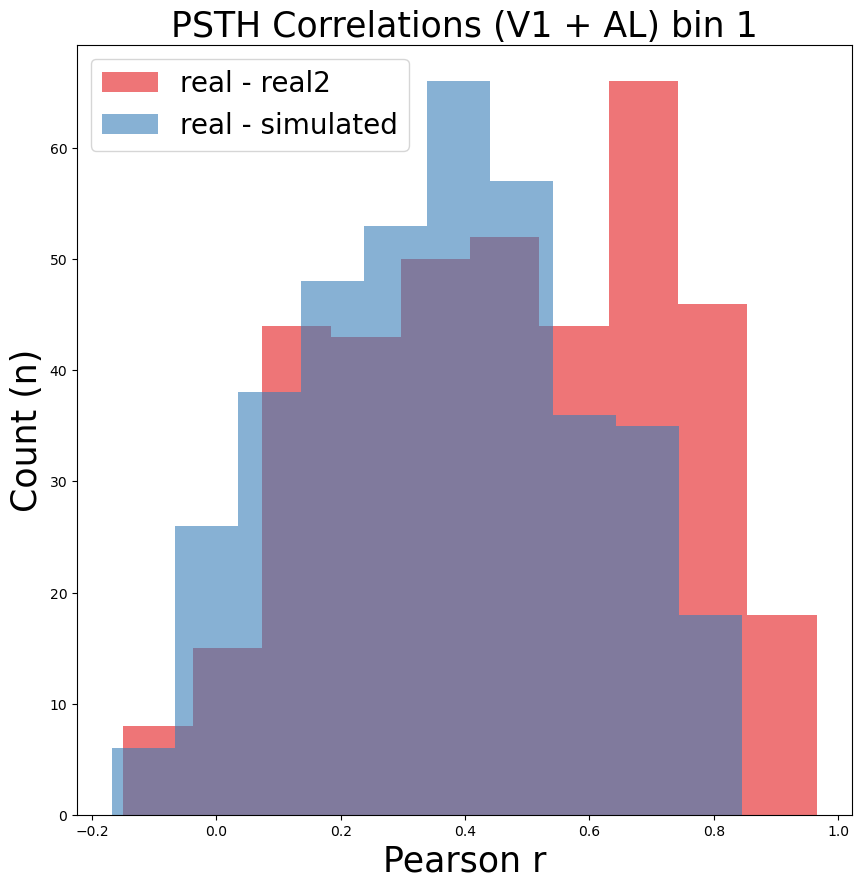

386


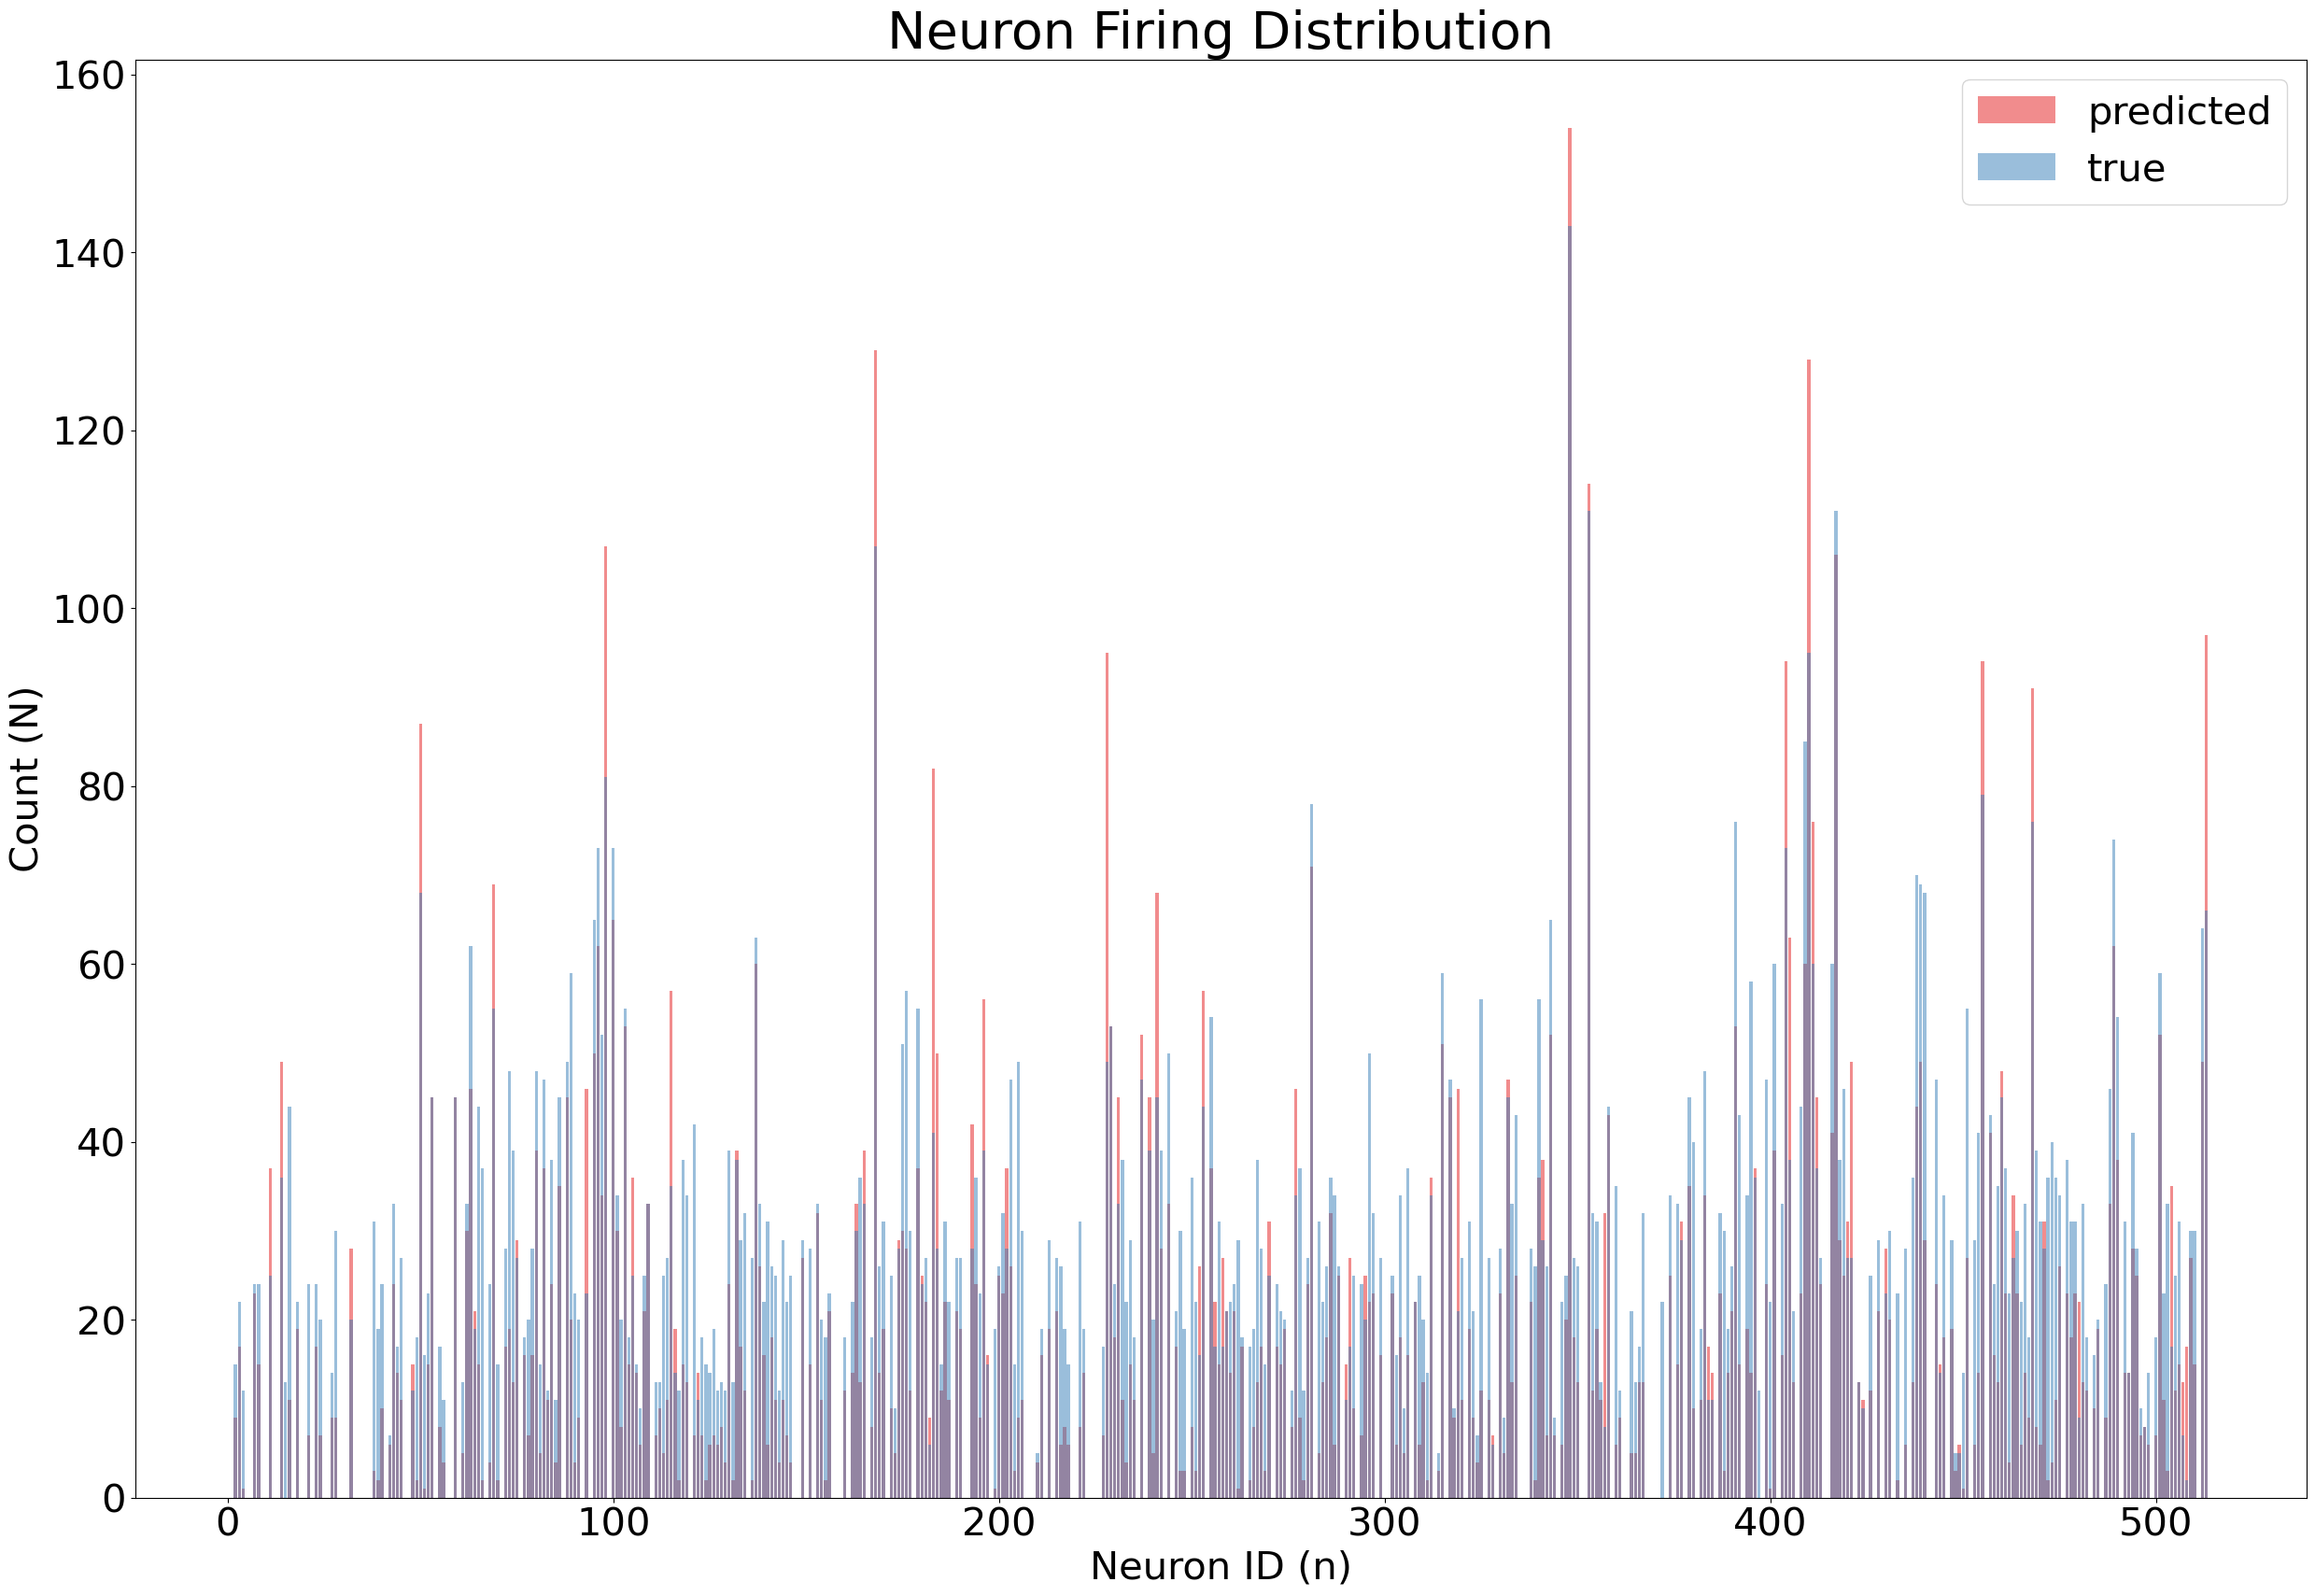

model: epoch250_randFalse_downstream:False/past_state_True_visualTrue_contrastive_False_freeze_False/randperm_False/Big_fixed_noself-att


In [67]:
"""

Evaluate results

"""


from neuroformer.visualize import set_plot_white, plot_distribution

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")

# dir_name = os.path.dirname(model_path)
save_dir = os.path.dirname(model_path)
df_pred.to_csv(os.path.join(save_dir, F'df_pred.csv'))

set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) bin {window_pred}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6)
plt.legend(fontsize=20)
plt.savefig(os.path.join(dir_name, F'psth_corr.svg'))
plt.show()

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores

print(f"model: {title}")



In [51]:
loader = DataLoader(test_dataset, shuffle=False, pin_memory=False)
iterable = iter(test_dataset)




In [52]:
var_group = 'Interval'
int_trials = df.groupby([var_group, 'Trial']).size()
print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
n_unique = len(df.groupby([var_group, 'Trial']).size())
df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# df.groupby(['Interval_2', 'Trial']).size().mean()




2.2172952440017055


Interval  Trial
19.40     21       16
0.40      35       15
6.65      22       14
0.40      34       13
0.60      21       13
                   ..
7.30      20        3
          30        3
          52        3
          54        3
7.35      3         3
Length: 5159, dtype: int64

In [53]:
# while iv < 1.95:
x, y = next(iterable)

T = len(x['id'])
P = x['pad']
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

T_y = len(y['id'])
P_y = x['pad']

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]
xdt = x['dt'][: T - P]

yid = y['id'][: T_y - P_y]
yid = [itos[int(i)] for i in yid]
ydt = y['dt'][: T - P]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")
print(f"xdt: {xdt}")
print(f"y: {yid}")
print(f"ydt: {ydt}")

print(f"xid_prev: {xid_prev}")

tdiff = 0
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

# t_var = 'Time' # 'Interval'
# int_var = 'pid'
# df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))

# print(f"trial: {x['trial']}, pid: {x['pid']}, cid: {x['cid']}")

# plt.imshow(x['frames'][0, 0])


iv: 0.25, ix+window: 0.3 pid: tensor([0.0000, 0.2500]) cid: tensor([0.2500, 0.3000])
x: ['SOS', 488, 440, 21]
xdt: tensor([0., 0., 5., 5.])
y: [488, 440, 21, 'EOS']
ydt: tensor([ 0,  5,  5, 26])
xid_prev: ['SOS', 484, 309, 440, 241, 328, 433, 322, 477, 239, 86, 11, 451, 477, 277, 451, 509, 380, 'EOS', 'PAD', 'PAD', 'PAD']


,Unnamed: 0,Time,ID,Trial,Interval,real_interval,Interval_2
17,17,0.252502,488,1,0.3,0.3,0.5
18,18,0.295416,440,1,0.3,0.3,0.5
19,19,0.297087,21,1,0.3,0.3,0.5


In [54]:
itos_dt



{0: 0.0,
 1: 0.01,
 2: 0.02,
 3: 0.03,
 4: 0.04,
 5: 0.05,
 6: 0.06,
 7: 0.07,
 8: 0.08,
 9: 0.09,
 10: 0.1,
 11: 0.11,
 12: 0.12,
 13: 0.13,
 14: 0.14,
 15: 0.15,
 16: 0.16,
 17: 0.17,
 18: 0.18,
 19: 0.19,
 20: 0.2,
 21: 0.21,
 22: 0.22,
 23: 0.23,
 24: 0.24,
 25: 0.25,
 26: 'EOS',
 27: 'PAD'}

In [55]:
loader = DataLoader(test_dataset, shuffle=True, pin_memory=False)
iterable = iter(loader)



In [56]:
x, y = next(iterable)
preds, features, loss = model(x, y)





